In [16]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.DataFrame(pd.read_excel("Traindata.xlsx"))
intersection_columns = ['InterSection1']
traffic_columns = ['TrafficDensity1']
x = data[['InterSection1']]
y = data['TrafficDensity1']
test_size_percentage = 0.3 # Set the desired percentage for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size_percentage, random_state=42)
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

test_data = pd.read_excel("Final_withactual.xlsx")
x_test1 = test_data[['InterSection1']].values.reshape(-1, 1)
y_pred1 = dt.predict(x_test1)

x_test2 = test_data[['InterSection2']].values.reshape(-1, 1)
y_pred2 = dt.predict(x_test2)

x_test3 = test_data[['InterSection3']].values.reshape(-1, 1)
y_pred3 = dt.predict(x_test3)

x_test4 = test_data[['InterSection4']].values.reshape(-1, 1)
y_pred4 = dt.predict(x_test4)


# Create a DataFrame with the predicted values
df = pd.DataFrame({
    'InterSection1': y_pred1,
    'InterSection2': y_pred2,
    'InterSection3': y_pred3,
    'InterSection4': y_pred4
})

#print(df)

label_mapping = {
    'Very Light': 1,
    'Light': 2,
    'Moderate': 3,
    'Heavy': 4,
    'Very Heavy': 5
}

# Iterate over rows and assign ranks
for i, row in df.iterrows():
    ranks = [label_mapping[label] for label in row.values]
    df.loc[i] = ranks
#print(df)

#Create a DataFrame with the predicted values
df = pd.DataFrame({
    'Lane1': y_pred1,
    'Lane2': y_pred2,
    'Lane3': y_pred3,
    'Lane4': y_pred4
})

# Iterate over rows, assign ranks, sort ranks, and assign intersection names
for i, row in df.iterrows():
    ranks = [label_mapping[label] for label in row.values]
    sorted_ranks = sorted(range(len(ranks)), key=lambda x: (ranks[x], x), reverse=True)
    intersections = ['Lane' + str(index + 1) for index in sorted_ranks]
    df.loc[i, 'Sorted_Result'] = ', '.join(intersections)
    
print(df)



# #Decision tree part........................................................................
df = pd.DataFrame(test_data)
# Extract intersection data into arrays
intersection_arrays = []
for _, row in df.iterrows():
    intersection_data = []
    for i in range(1, 5):  # Assuming there are always 4 intersections
        intersection_data.append(row[f'InterSection{i}'])
    intersection_arrays.append(intersection_data)

#print(intersection_arrays)
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Green light times data
green_light_times = {
    (0,): 0,
    (1,): 10,
    (2,): 15,
    (3,): 20,
    (4,): 25,
    (5,): 30,
    (6,): 35,
    (7,): 40,
    (8,): 45
}

# Convert green light times data to arrays for training
x_traing = np.array(list(green_light_times.keys())).reshape((-1, 1))  # Reshape for compatibility with sklearn
y_traing = np.array(list(green_light_times.values()))

# Instantiate PolynomialFeatures object to generate polynomial features
poly = PolynomialFeatures(degree=2)

# Transform the input features to include polynomial features
x_train_poly = poly.fit_transform(x_traing)

# Train polynomial regression model
model = LinearRegression()
model.fit(x_train_poly, y_traing)
# Define a function to predict green light time for a given number of cars
def predict_green_light_time(cars):
    total_time = 0
    for car in cars:
        car_array = np.array([[car]])  # Reshape the input for compatibility with model prediction
        car_array_poly = poly.transform(car_array)  # Transform input for polynomial regression
        predicted_time = model.predict(car_array_poly)[0]
        total_time += predicted_time
    return total_time

# Test input
test_input = intersection_arrays
results_df = pd.DataFrame(columns=['Sorted_Result', 'Predicted_Times', 'Total_Predicted_Time'])
results_list = []
for i, row in enumerate(test_input):
    predicted_times = [model.predict(poly.transform(np.array([[car]])))[0] for car in row]
    sorted_predicted_times = sorted(predicted_times, reverse=True)  # Sort predicted times in descending order
    total_time = sum(sorted_predicted_times)
    total_time_rounded = round(total_time)
    
    # Create a dictionary to store the results for each row
    result_dict = {}
    
    # Split sorted result into four lanes
    sorted_result = [f'Lane{index + 1}' for index in np.argsort(predicted_times)[::-1]]
    for j in range(4):
        result_dict[f'Sorted_Lane_{j + 1}'] = sorted_result[j]
    
    # Add columns for predicted times for each lane
    for j, time in enumerate(sorted_predicted_times):
        result_dict[f'Predicted_Time_{j + 1}'] = round(time)
    
    # Add column for total time
    result_dict['Total_Predicted_Time'] = total_time_rounded
    
    results_list.append(result_dict)

# Convert list of dictionaries to DataFrame
results_df = pd.DataFrame(results_list)

# Reorder columns so that total time appears at the last column
column_order = [col for col in results_df.columns if col != 'Total_Predicted_Time'] + ['Total_Predicted_Time']
results_df = results_df[column_order]
results_df.to_excel(r"C:\Users\User\Desktop\AI_traffic_dataset\predicted_traffic_times.xlsx", index=False)


         Lane1       Lane2       Lane3       Lane4               Sorted_Result
0        Light  Very Light    Moderate  Very Light  Lane3, Lane1, Lane4, Lane2
1     Moderate       Light       Heavy  Very Light  Lane3, Lane1, Lane2, Lane4
2        Heavy       Light  Very Light  Very Light  Lane1, Lane2, Lane4, Lane3
3        Heavy       Light       Light  Very Light  Lane1, Lane3, Lane2, Lane4
4        Light  Very Light  Very Light       Light  Lane4, Lane1, Lane3, Lane2
5        Heavy  Very Light    Moderate  Very Light  Lane1, Lane3, Lane4, Lane2
6        Light  Very Light    Moderate  Very Light  Lane3, Lane1, Lane4, Lane2
7     Moderate  Very Light       Light  Very Light  Lane1, Lane3, Lane4, Lane2
8        Light  Very Light       Light  Very Light  Lane3, Lane1, Lane4, Lane2
9        Heavy  Very Light       Heavy       Light  Lane3, Lane1, Lane4, Lane2
10       Light  Very Light       Light  Very Light  Lane3, Lane1, Lane4, Lane2
11       Light       Light       Light  Very Light  

c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [17]:
results_df

,Sorted_Lane_1,Sorted_Lane_2,Sorted_Lane_3,Sorted_Lane_4,Predicted_Time_1,Predicted_Time_2,Predicted_Time_3,Predicted_Time_4,Total_Predicted_Time
0,Lane3,Lane1,Lane4,Lane2,25,14,2,2,43
1,Lane3,Lane1,Lane2,Lane4,31,25,14,2,72
2,Lane1,Lane2,Lane4,Lane3,31,20,8,8,67
3,Lane1,Lane3,Lane2,Lane4,36,14,14,8,72
4,Lane1,Lane4,Lane3,Lane2,20,14,8,2,44
5,Lane1,Lane3,Lane4,Lane2,31,25,2,2,59
6,Lane3,Lane1,Lane4,Lane2,25,20,2,2,49
7,Lane1,Lane3,Lane4,Lane2,25,20,2,2,49
8,Lane3,Lane1,Lane4,Lane2,14,14,8,2,38
9,Lane3,Lane1,Lane4,Lane2,36,31,14,2,82


Classification Report for Intersection 1:
              precision    recall  f1-score   support

       Heavy       1.00      1.00      1.00         6
       Light       1.00      1.00      1.00        15
    Moderate       1.00      1.00      1.00         7
  Very Heavy       1.00      1.00      1.00         6
  Very Light       1.00      1.00      1.00         6

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix for Intersection 1:
[[ 6  0  0  0  0]
 [ 0 15  0  0  0]
 [ 0  0  7  0  0]
 [ 0  0  0  6  0]
 [ 0  0  0  0  6]]


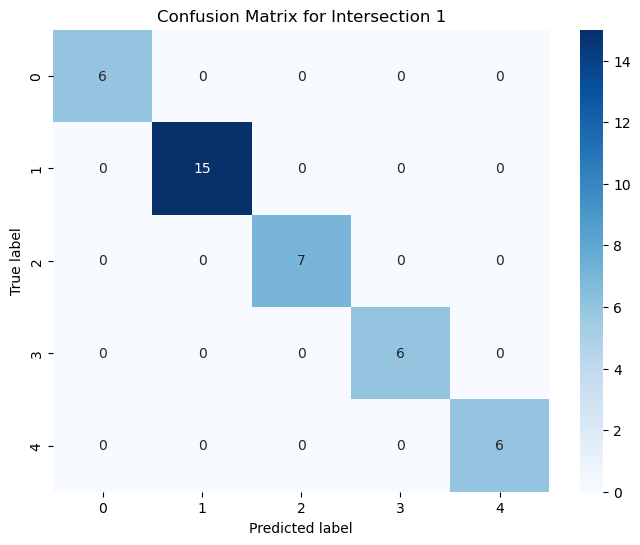

Classification Report for Intersection 2:
              precision    recall  f1-score   support

       Light       1.00      1.00      1.00         7
  Very Light       1.00      1.00      1.00        33

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix for Intersection 2:
[[ 7  0]
 [ 0 33]]


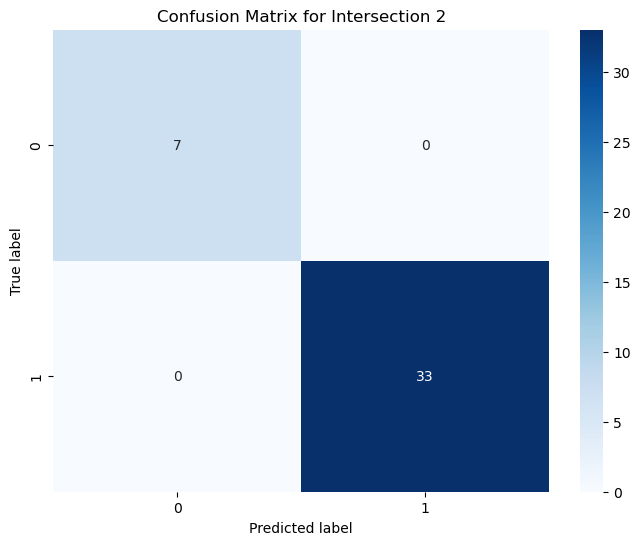

Classification Report for Intersection 3:
              precision    recall  f1-score   support

       Heavy       1.00      1.00      1.00        12
       Light       1.00      1.00      1.00         8
    Moderate       1.00      1.00      1.00         6
  Very Heavy       1.00      1.00      1.00        10
  Very Light       1.00      1.00      1.00         4

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix for Intersection 3:
[[12  0  0  0  0]
 [ 0  8  0  0  0]
 [ 0  0  6  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0  4]]


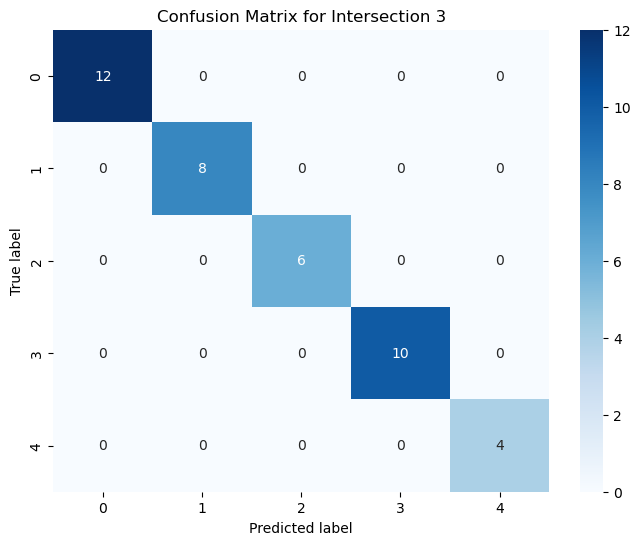

Classification Report for Intersection 4:
              precision    recall  f1-score   support

       Heavy       1.00      1.00      1.00         1
       Light       1.00      1.00      1.00        16
  Very Light       1.00      1.00      1.00        23

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix for Intersection 4:
[[ 1  0  0]
 [ 0 16  0]
 [ 0  0 23]]


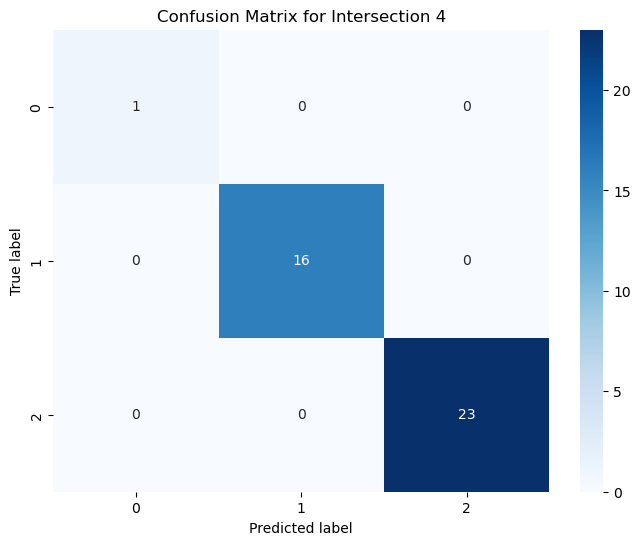

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

actual_1 =test_data[['actual_1']]
actual_2 =test_data[['actual_2']]
actual_3 =test_data[['actual_3']]
actual_4 =test_data[['actual_4']]

# Calculate classification report and confusion matrix for each intersection
for i, (y_pred, actual) in enumerate(zip([y_pred1, y_pred2, y_pred3, y_pred4], [actual_1, actual_2, actual_3, actual_4]), start=1):
    # Calculate classification report
    class_report = classification_report(actual, y_pred)
    print(f"Classification Report for Intersection {i}:")
    print(class_report)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(actual, y_pred)
    print(f"Confusion Matrix for Intersection {i}:")
    print(conf_matrix)
    
    # Plot confusion matrix as an image
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for Intersection {i}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()



In [19]:
# Import necessary libraries
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions on the training data
y_train_pred = model.predict(x_train_poly)

# Calculate MAE, MSE, and R^2 on the training data
mae_train = mean_absolute_error(y_traing, y_train_pred)
r2_train = r2_score(y_traing, y_train_pred)

# Print the results
print("Training Set Metrics:")
print("Mean Absolute Error (MAE):", mae_train)
print("R-squared (R^2):", r2_train)


Training Set Metrics:
Mean Absolute Error (MAE): 0.7542087542087494
R-squared (R^2): 0.9950733137829912
